<a href="https://colab.research.google.com/github/benmsanderson/esmperspective/blob/main/ESGF_read_harvest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.simplefilter("ignore")

from itertools import groupby

In [2]:
pip install nc-time-axis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00


In [3]:
pip install h5pyd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h5pyd: filename=h5pyd-0.18.0-py3-none-any.whl size=169256 sha256=9583d4625e1886623ed747feec5ce21316d23ae5ec7931ca9c7e505a843e7e87
  Stored in directory: /root/.cache/pip/wheels/f9/16/49/01a9e2ca681050918c2f2aeec99dad84a7c24a612a40c2f661
Successfully built h5pyd


In [4]:
 pip install netcdf4==1.6.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 16.8 MB/s eta 0:00:00


In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5pyd
import xarray as xr
import nc_time_axis

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Search using ESGF API

In [6]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    payload["latest"]="true"

    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        #print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    result=sorted(all_files)
    tmp = [[c for _, c in g] for _, g in groupby(zip( [x.split('_')[-3] for x in result],result), key=lambda x: x[0])]
    return tmp

In [7]:
dset_34={}
dset_85={}

In [8]:
mdls=["CESM2-WACCM","UKESM1-0-LL","IPSL-CM6A-LR"]
runs=["r1i1p1f1","r1i1p1f2","r1i1p1f1"]

In [9]:
for i,mdl in enumerate(mdls):

  result_hist = esgf_search(activity_id='CMIP', table_id='Lmon',
                      experiment_id='historical', variable_id='fHarvest',
                      source_id=mdl,member_id=runs[i])
  result_ssp534 = esgf_search(activity_id='ScenarioMIP', table_id='Lmon',
                      experiment_id='ssp534-over', variable_id='fHarvest',
                      source_id=mdl,member_id=runs[i])
  result_ssp585 = esgf_search(activity_id='ScenarioMIP', table_id='Lmon',
                      experiment_id='ssp585', variable_id='fHarvest',
                      source_id=mdl,member_id=runs[i])

  ds_585 = xr.open_mfdataset(result_hist[0]+result_ssp585[0], combine='by_coords',use_cftime=True)
  ds_534_end = xr.open_mfdataset(result_ssp534[0], combine='by_coords',use_cftime=True)
  ds_534=xr.concat((ds_585.sel(time=slice("1850-01-01", "2039-12-30")),ds_534_end),'time')

  files_area = esgf_search(variable_id='areacella', activity_id='CMIP',
                          source_id=mdl)
  ds_area = xr.open_dataset(files_area[0][0])

  total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
  ts_585 = (ds_585['fHarvest'] * ds_area.areacella.values).sum(dim=['lon', 'lat'])
  ts_534 = (ds_534['fHarvest'] * ds_area.areacella.values).sum(dim=['lon', 'lat'])

  ts_534.load()
  ts_585.load()
  dset_34[mdl]=ts_534.copy()
  dset_85[mdl]=ts_585.copy()


In [32]:
iam_db=pd.read_excel('https://github.com/benmsanderson/esmperspective/raw/main/iamc_db.xlsx',index_col='Model')
iam_db_BECCS=pd.read_excel('https://github.com/benmsanderson/esmperspective/raw/main/iamc_db_BECCS.xlsx',index_col='Model')
iam_db_food=pd.read_excel('https://github.com/benmsanderson/esmperspective/raw/main/iamc_db_food.xlsx',index_col='Model')



In [58]:
iam_db

,Scenario,Region,Variable,Unit,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100,Notes
Model,,,,,,,,,,,,,,,,
AIM/CGE,SSP5-34,World,Agricultural Production|Crops|Energy,million t DM/yr,0.000000,0.000000,23.495300,157.460200,2636.293800,5858.842900,8919.592800,12177.801100,14454.468600,16564.026500,18478.677600,NaN
AIM/CGE,SSP5-Baseline,World,Agricultural Production|Crops|Energy,million t DM/yr,0.000000,0.000000,22.123300,58.237500,165.859700,510.594800,1016.352100,1696.564400,2509.527500,3240.675200,4134.463500,NaN
GCAM4,SSP5-34,World,Agricultural Production|Crops|Energy,million t DM/yr,NaN,0.000000,425.701329,730.506888,1885.309920,3029.574015,3663.004098,4465.388030,5784.867911,7130.316663,8137.508991,NaN
GCAM4,SSP5-Baseline,World,Agricultural Production|Crops|Energy,million t DM/yr,NaN,0.000000,382.541372,660.010010,937.866232,1145.236649,1272.903473,1272.209514,1236.263841,1211.793100,1146.673041,NaN
IMAGE,SSP5-34,World,Agricultural Production|Crops|Energy,million t DM/yr,30.231405,57.345635,172.014789,388.940395,688.294793,1185.369391,1109.343389,1064.020187,1807.324727,2000.070984,2540.931156,NaN
IMAGE,SSP5-Baseline,World,Agricultural Production|Crops|Energy,million t DM/yr,31.355987,57.292105,177.706304,523.338924,1303.640470,2386.873723,2135.040018,1335.669543,1815.856523,2133.981352,1856.921676,NaN
REMIND-MAGPIE,SSP5-34,World,Agricultural Production|Crops|Energy,million t DM/yr,25.325500,11.213800,83.659900,74.239100,109.734000,1157.429900,5030.808100,9704.882200,14470.651000,18761.840600,19915.488200,NaN
REMIND-MAGPIE,SSP5-Baseline,World,Agricultural Production|Crops|Energy,million t DM/yr,25.325500,11.213800,84.564500,87.532000,66.829400,31.205900,34.324900,23.590300,17.276100,58.895100,189.018000,NaN
© SSP Public Database (Version 2.0) https://tntcat.iiasa.ac.at/SspDb \n generated: 2024-05-28 18:41:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
iam_beccs=iam_db_BECCS[iam_db_BECCS['Scenario'] == 'SSP5-Baseline'].iloc[:,5:-1]*12/44/1000
iam_food=iam_db_food[iam_db_food['Scenario'] == 'SSP5-Baseline'].iloc[:,5:-1]*0.45/1000
iam_energy=iam_db[iam_db['Scenario'] == 'SSP5-Baseline'].iloc[:,5:-1]*0.45/1000


iam_beccs_os=iam_db_BECCS[iam_db_BECCS['Scenario'] == 'SSP5-34'].iloc[:,5:-1]*12/44/1000
iam_food_os=iam_db_food[iam_db_food['Scenario'] == 'SSP5-34'].iloc[:,5:-1]*0.45/1000
iam_energy_os=iam_db[iam_db['Scenario'] == 'SSP5-34'].iloc[:,5:-1]*0.45/1000

In [47]:
iam_beccs

,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Model,,,,,,,,,,
GCAM4,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
IMAGE,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
REMIND-MAGPIE,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
WITCH-GLOBIOM,0.00002,0.000013,0.000012,0.00001,0.00001,0.000011,0.000012,0.000013,0.000014,0.002429


In [67]:
(iam_energy_os-iam_energy)

,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Model,,,,,,,,,,
AIM/CGE,0.000000,0.000617,0.044650,1.111695,2.406712,3.556458,4.716557,5.375223,5.995508,6.454896
GCAM4,0.000000,0.019422,0.031724,0.426350,0.847952,1.075545,1.436930,2.046872,2.663336,3.145876
IMAGE,0.000024,-0.002561,-0.060479,-0.276906,-0.540677,-0.461563,-0.122242,-0.003839,-0.060260,0.307804
REMIND-MAGPIE,0.000000,-0.000407,-0.005982,0.019307,0.506801,2.248417,4.356581,6.504019,8.416325,8.876912


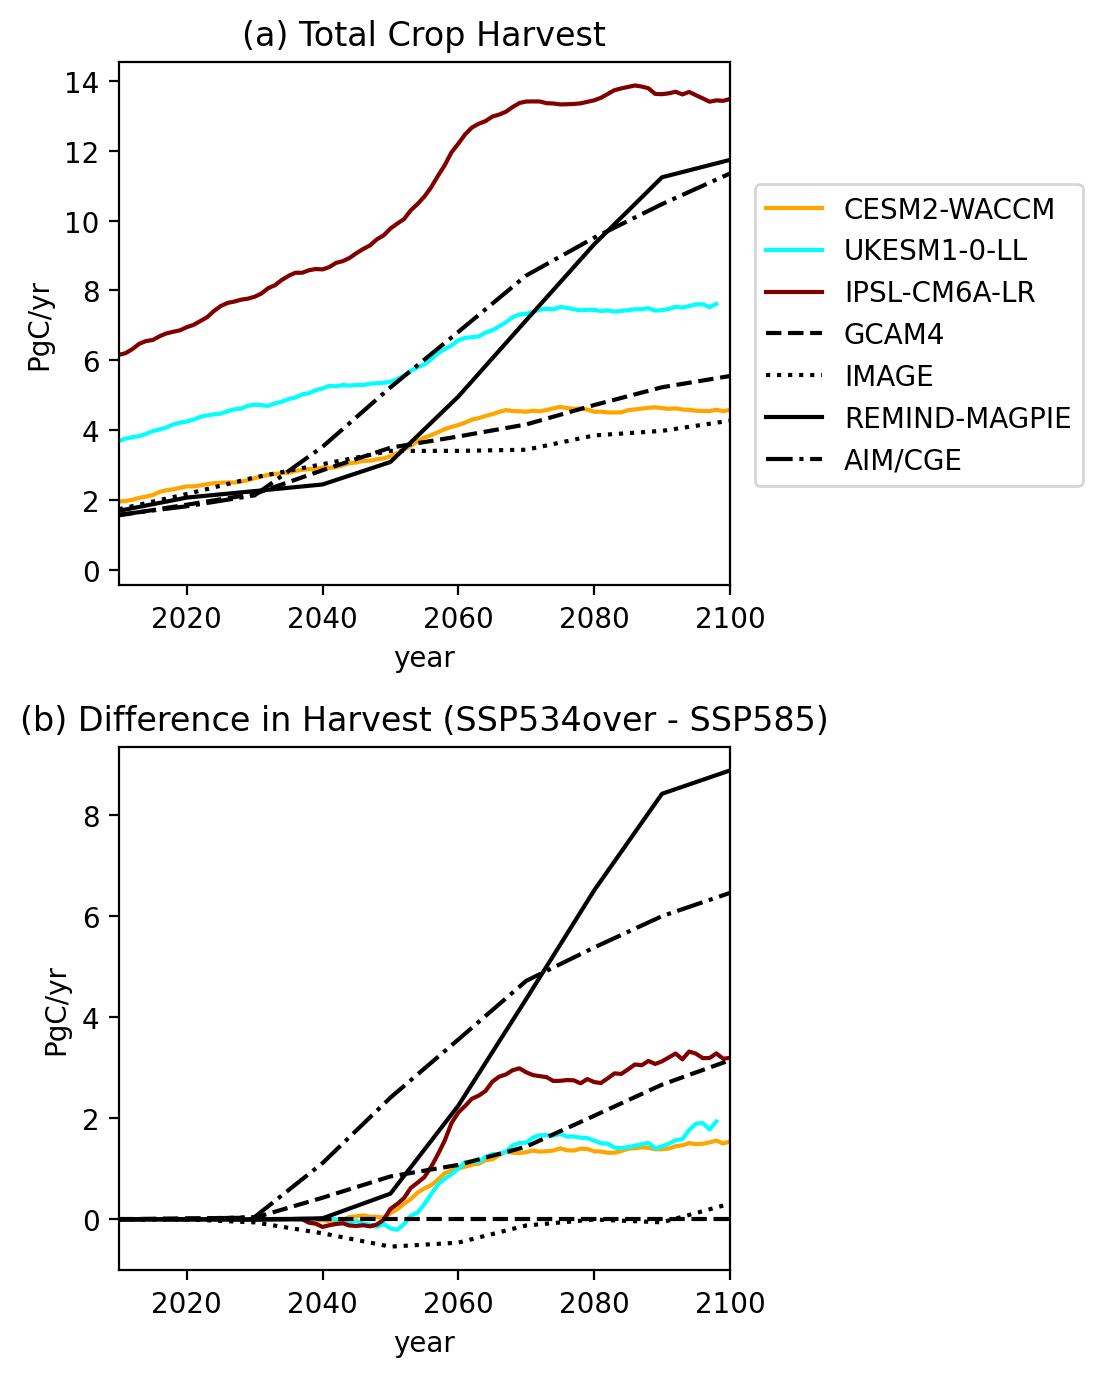

In [88]:
#iam_beccs=np.array([0.000,0.168,	43.300,	477.000,	2020.000,	5780.000,	10200.000,	14900.000,	19400.000,	21100.000])*12/44/1000
#iam_food=np.array([3758.809,4527.752	,4950.724,	5335.194	,5716.100,	6003.412,	6179.976,	6239.496,	6211.187,	6163.502])*0.45/1000
#iam_energy=np.array([11.214,	83.660,	74.239,	109.734,	1157.430,	5030.808,	9704.882,	14470.651,	18761.841,	19915.488])*0.45/1000
styls= {'GCAM4': '--', 'IMAGE': ':', 'REMIND-MAGPIE': '-','AIM/CGE':'-.'}
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(4,7))


iamt=np.arange(2010,2110,10)
#ta_timeseries.plot(label='monthly')
cnv=365*24*3600/1e12
cols=['orange','cyan','maroon']
for i,mdl in enumerate(mdls):
#  (dset_85[mdl]*cnv).groupby(dset_85[mdl]['time.year']).mean('time').plot(color=cols[i],label=mdl)
  (dset_34[mdl]*cnv-dset_85[mdl]*cnv).groupby(dset_34[mdl]['time.year']).mean('time').rolling(year=5, center=True).mean().plot(color=cols[i],linestyle='-',label=mdl,ax=ax[1])

#ax[1].plot(iamt,iam_beccs,'k:')
for m in styls.keys():
  ax[1].plot(iamt,(iam_energy_os-iam_energy).loc[m].T,'k',linestyle=styls[m],label=m)
ax[1].plot([2000,2100],[0,0],'k--')

ax[1].set_title('(b) Difference in Harvest (SSP534over - SSP585)')
ax[1].set_ylabel('PgC/yr')
ax[1].set_xlim([2010,2100])



for i,mdl in enumerate(mdls):
 # (dset_85[mdl]*cnv).groupby(dset_85[mdl]['time.year']).mean('time').rolling(year=5, center=True).mean().plot(color=cols[i],linestyle='--',ax=ax[0])
  (dset_34[mdl]*cnv).groupby(dset_34[mdl]['time.year']).mean('time').rolling(year=5, center=True).mean().plot(color=cols[i],linestyle='-',ax=ax[0])

#ax[0].plot(iamt,iam_food.T,'k--',label='SSP5-85')
for m in styls.keys():
  ax[0].plot(iamt,(iam_food_os+iam_energy_os).loc[m].T,'k',linestyle=styls[m],label=m)
ax[0].set_title('(a) Total Crop Harvest')
ax[0].set_ylabel('PgC/yr')
ax[0].set_xlim([2010,2100])
plt.tight_layout()
ax[1].legend(bbox_to_anchor=(1.6, 2.1))
#ax[0].legend(bbox_to_anchor=(1.5, .2))


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
iam_energy

array([5.04630000e-03, 3.76470000e-02, 3.34075500e-02, 4.93803000e-02,
       5.20843500e-01, 2.26386360e+00, 4.36719690e+00, 6.51179295e+00,
       8.44282845e+00, 8.96196960e+00])